In [148]:
import pandas as pd
import re
import matplotlib
import numpy as np
from math import log, floor
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

# Motivation
The Wall Street Journal put out an article on May 31, 2017 with the title [_Though Outnumbered, Female CEOs Earn More Than Male Chiefs_](https://www.wsj.com/articles/women-ceos-dont-get-paid-less-than-men-in-big-business-they-make-more-1496223001). I was intrigued and a bit skeptical and then I noticed they reported the median earnings. Median would normally be a good way to compare but I was curious about the distribution of the compensation since there are only 23 women CEOs at S&P 500 companies this year.

# Data Source
The data was scraped from the AFL-CIO page on CEO compensation using ImportIO to save time on scraping the data.
The format of the URLs was as follows:
- https://aflcio.org/paywatch/highest-paid-ceos?combine=&industry=All&state=All&sp500=0&page=152
- https://aflcio.org/paywatch/highest-paid-ceos?combine=&industry=All&state=All&r3000=0&page=152

I used the link generator tool in [ImportIO](https://www.import.io/) since the page values range from 0 to 152.
I saved the data in both csv and json ('cause why not?) and grabbed the data for the S&P 500 and the Russell 3000 companies (also, why not?). The links above correspond to the S&P 500 (first link) and Russell 3000 (second link).

The data seems to have mixed years and I'm not terribly sure what that means exactly but it was the best data I found in the short amount of time I had to get the analysis done.

## Import the data using Pandas

In [2]:
raw_data = pd.read_csv('Highest_Paid_CEOs_SP500.csv')

In [3]:
raw_data.columns

Index(['url', 'Ticker', 'Ticker_link', 'Company', 'Company_link', 'Ceo',
       'Year', 'Compensation'],
      dtype='object')

Here we want to clean up the data a little. First we collect only the relevant columns in to the DataFrame `ceo_pay` and then we need to remove the $ in the compensation column to make the data numeric rather than a string for our analysis later. This gives me a warning about setting a value on a slice of a DataFrame. [I'm not sure what this error means](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas) but it works nonetheless. While we're editing this data we'll also rescale the compensation to be in units of _Million USD_.

We'll also plop out a quick plot using pandas `plot` function. The y-axis would be impossible to read since we'll have all 3000+ CEO names, so we'll plot every 100th. We're just trying to get a general sense of the distribution before pulling out the top 500 female and male CEOs. I'm choosing to make the figure 7 in x 5 in so we can easily read the CEO names. (I played around with taller options but I don't want to take up a lot of space on a preliminary graph.)

In [4]:
ceo_pay = raw_data[['Ceo','Company', 'Compensation']].copy()
ceo_pay['Compensation'] = ceo_pay['Compensation'].str.replace(r'\$','').str.replace(',','').astype('int')/1e6

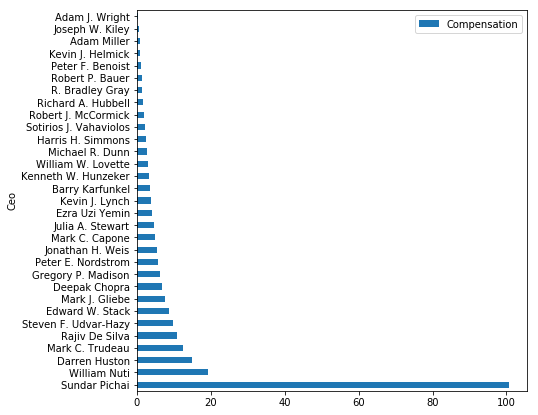

In [5]:
ceo_pay[::100].plot.barh(x='Ceo', y='Compensation',figsize=(7,7))

Before I mentioned that there are 3000+ CEOs in our data, which is why we only plotted 30. This was unexpected since we thought we were looking at the S&P 500 companies only, but it turns out we've scraped more than that (I'm not sure how since the site only should be giving us the S&P 500 companies and there are no duplicates). We'll fix it later, but first we'll find out how much data we have.

In [6]:
len(raw_data.Ceo.unique())

3031

# Who are the Female CEOs?

## Finding our top female CEOs
I was able to find a list of female ceos from the following sites:

- [Wikipedia](https://en.wikipedia.org/wiki/List_of_women_CEOs_of_Fortune_500_companies)
- [Catalyst](http://www.catalyst.org/knowledge/women-ceos-sp-500?page=1)

The reasoning behind using these two lists was the variation given in the names, i.e., Mary Barra vs. Mary T. Barra or Patti Poppe vs. Patricia K. Poppe. The intention behind using this combined set of names was to maximize the chance of a match when masking the pandas DataFrame to find the data specific to our female CEOS. I copied the lists in and cleaned them up a little by hand. I split the string and cleaned extra spaces. I combined the two lists using a set to remove any duplicates that may be present.

In [7]:
female_ceos1 = 'Mary Barra, Virginia Rometty, Indra K. Nooyi, Marillyn Hewson, Safra A. Catz, Phebe Novakovic,\
Irene B. Rosenfeld, Lynn Good, Shira Goodman, S. Tricia Griffith, Geisha Williams, Vicki Hollub,\
Deanna M. Mulligan, Barbara Rentler, Debra Crew, Anna Manning, Debra L. Reed, Kimberly Lubel, Mary Laschinger,\
Denise M. Morrison, Michele Buck, Sheri S. McCoy, Patti Poppe, Kathleen Mazzarella, Margo Georgiadis, \
Ilene Gordon, Jacqueline C. Hinman'
female_ceos1 = female_ceos1.split(',')
female_ceos1 = [x.strip() for x in female_ceos1]

female_ceos2 = 'Mary T. Barra, Heather Bresch, Michele Buck, Debra A. Cafaro, Safra A. Catz, Debra Crew,\
                Mary Dillon, Adena Friedman, Margaret "Margo" Georgiadis, Lynn J. Good, Shira Goodman,\
                Tricia Griffith, Marillyn A. Hewson, Vicki Hollub, Margaret Keane, Gracia C. Martore,\
                Marissa Mayer, Beth E. Mooney, Denise M. Morrison, Indra K. Nooyi, Phebe N. Novakovic,\
                Patricia K. Poppe, Debra L. Reed, Barbara Rentler, Virginia M. Rometty, Irene B. Rosenfeld,\
                Susan N. Story, Meg Whitman, Geisha Williams'
female_ceos2 = female_ceos2.split(',')
female_ceos2 = [x.strip() for x in female_ceos2]
female_ceos = set(female_ceos1+female_ceos2)
print('Duplicates present: {}\n{} out companies with female CEOs, 23 expected.'.format(len(female_ceos) != len(female_ceos1) + len(female_ceos2), ceo_pay[ceo_pay.Ceo.isin(female_ceos)].shape[0]))

Duplicates present: True
16 out companies with female CEOs, 23 expected.


## Where are the missing CEOs?
We were expecting 23 female CEOs in the data but that's not what we got using the names.

[Fortune](http://beta.fortune.com/fortune500/list/filtered?ceowoman=true)

In [8]:
# Copied and pasted this off a website (used the checker below to determine which names agreed.
# If they didn't I fixed them up here. I added the semicolons to allow me to split the string)
companies_w_female_ceo = 'General Motors Company$152,356;\
31International Business Machines Corporation$82,461\
;44Pepsico$63,056\
;60Lockheed Martin Corporation$46,132\
;77Oracle Corporation$38,226\
;88General Dynamics Corporation$31,469\
;94Mondelez International$29,636\
;115Duke Energy Corporation$24,002\
;150Xerox Corporation$18,664\
;225Occidental Petroleum Corporation$12,699\
;226Guardian Life Ins. Co. of America$12,628\
;237Ross Stores$11,940\
;266Reynolds American$10,675\
;269Hertz Global Holdings$10,535\
;271Reinsurance Group of America$10,418\
;279Sempra Energy$10,231\
;299CST Brands$9,499\
;323Veritiv Corporation$8,718\
;337Campbell Soup Company$8,082\
;370Avon Products$7,173\
;423Graybar Electric$6,110\
;456Ingredion$5,621\
;478CH2M Hill$5,362'

companies_w_female_ceo = companies_w_female_ceo.split(';')
companies_w_female_ceo = [re.sub(r'^\d{2,3}', '', x) for x in companies_w_female_ceo]
companies_w_female_ceo = [re.sub(r'\$\d+,\d+$', '', x) for x in companies_w_female_ceo]

In [9]:
#Check to see what's missing
list(filter(lambda x: x not in list(ceo_pay.Company.unique()), companies_w_female_ceo))
#can't find these 3 in the data :(

['Guardian Life Ins. Co. of America', 'Graybar Electric', 'CH2M Hill']

In [10]:
# Who is in the data
list(ceo_pay.Ceo[ceo_pay['Company'].isin(companies_w_female_ceo)].unique())

['Mark V. Hurd',
 'V.M. Rometty',
 'Indra K. Nooyi',
 'Mary T. Barra',
 'Phebe N. Novakovic',
 'Marillyn A. Hewson',
 'Irene Rosenfeld',
 'Ursula M. Burns',
 'Lynn J. Good',
 'Susan M. Cameron',
 'Vicki Hollub',
 'Denise M. Morrison',
 'Barbara Rentler',
 'A. Greig Woodring',
 'Debra L. Reed',
 'Ilene S. Gordon',
 'Mary A. Laschinger',
 'Sheri McCoy',
 'Kimberly S. Lubel',
 'John P. Tague']

In [11]:
#Who is missing from the data
list(filter(lambda x: x not in list(ceo_pay.Ceo[ceo_pay['Company'].isin(companies_w_female_ceo)].unique()), female_ceos))

['Anna Manning',
 'Gracia C. Martore',
 'Meg Whitman',
 'Ilene Gordon',
 'Marissa Mayer',
 'Virginia Rometty',
 'Deanna M. Mulligan',
 'Mary Barra',
 'Marillyn Hewson',
 'Safra A. Catz',
 'Patti Poppe',
 'Margo Georgiadis',
 'Jacqueline C. Hinman',
 'Beth E. Mooney',
 'Debra A. Cafaro',
 'Susan N. Story',
 'S. Tricia Griffith',
 'Adena Friedman',
 'Heather Bresch',
 'Kathleen Mazzarella',
 'Patricia K. Poppe',
 'Mary Laschinger',
 'Margaret "Margo" Georgiadis',
 'Irene B. Rosenfeld',
 'Michele Buck',
 'Mary Dillon',
 'Margaret Keane',
 'Phebe Novakovic',
 'Geisha Williams',
 'Debra Crew',
 'Virginia M. Rometty',
 'Kimberly Lubel',
 'Sheri S. McCoy',
 'Lynn Good',
 'Tricia Griffith',
 'Shira Goodman']

## Whomp, Whomp
Some of these names don't agree with the more current data. So I'll assume the new CEOs are paid the same. The Oracle CEO is a co-CEO so that's probably okay as is.

In [12]:
# Define new dataframes and limit the male ceo one to the remainder of the top 500 since we've 
# restricted female ceo to top 500 as well
female_ceo_pay = ceo_pay[ceo_pay['Company'].isin(companies_w_female_ceo)]
male_ceo_pay = ceo_pay[~ceo_pay['Company'].isin(companies_w_female_ceo)][:500-len(female_ceo_pay)]
graph_male_pay  = male_ceo_pay[::25]

In [13]:
female_ceo_pay.Compensation.describe()

count    20.000000
mean     16.052925
std       9.462020
min       5.077351
25%      10.326090
50%      13.223516
75%      20.769819
max      41.121896
Name: Compensation, dtype: float64

In [14]:
male_ceo_pay.Compensation.describe()

count    480.000000
mean      16.456374
std       10.619200
min        9.748332
25%       11.291432
50%       13.470003
75%       17.719189
max      100.632102
Name: Compensation, dtype: float64

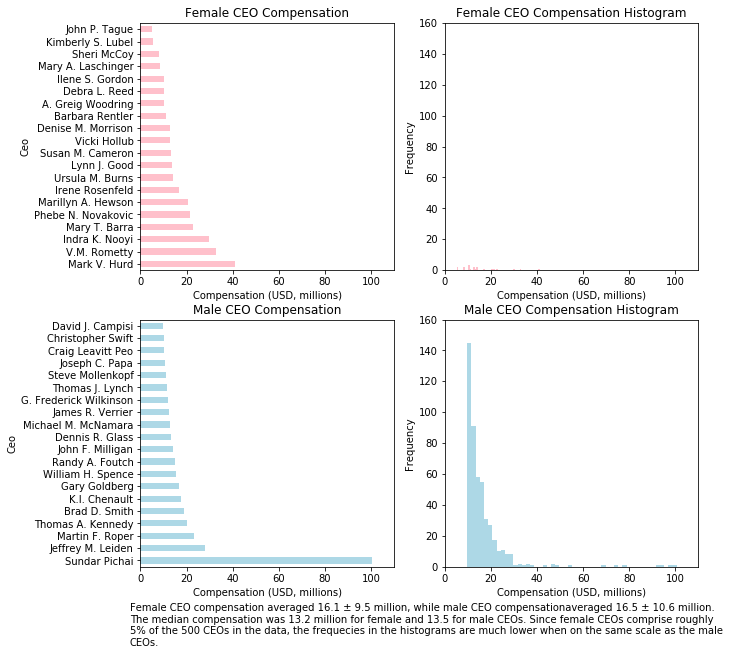

In [15]:
x_axis = (0, round(max([male_ceo_pay.Compensation.max(), female_ceo_pay.Compensation.max()]),0)+\
          (10 - round(max([male_ceo_pay.Compensation.max(), female_ceo_pay.Compensation.max()]),0)%10))
x_label = 'Compensation (USD, millions)'
title = 'Comparison of Male and Female CEO Compensation for Companies in the S&P 500'
caption = 'Female CEO compensation averaged {} \u00B1 {} million, while male CEO compensation\
averaged {} \u00B1 {} million.\nThe median compensation was {} million for female and {} for male CEOs. \
Since female CEOs comprise roughly\n5% of the 500 CEOs in the data, the frequecies in the histograms are \
much lower when on the same scale as the male\nCEOs.'.format(\
        round(female_ceo_pay.Compensation.mean(),1),round(female_ceo_pay.Compensation.std(),1),\
        round(male_ceo_pay.Compensation.mean(),1),round(male_ceo_pay.Compensation.std(),1),\
        round(female_ceo_pay.Compensation.median(),1), round(male_ceo_pay.Compensation.median(),1))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

female_ceo_pay.plot.hist(y='Compensation', color='pink',bins= 50, ylim=(0,160),legend=False,\
                         xlim=x_axis, ax=axes[0,1]); axes[0,1].set_title('Female CEO Compensation Histogram');

male_ceo_pay.plot.hist( y='Compensation', color='lightblue', bins=50,ylim=(0,160),legend=False,\
                       xlim=x_axis, ax=axes[1,1]); axes[1,1].set_title('Male CEO Compensation Histogram');

female_ceo_pay.plot.barh(x='Ceo', y='Compensation', color='pink',legend=False,\
                         xlim=x_axis, ax=axes[0,0]); axes[0,0].set_title('Female CEO Compensation');

graph_male_pay.plot.barh(x='Ceo', y='Compensation', color='lightblue', legend=False,\
                       xlim=x_axis, ax=axes[1,0]); axes[1,0].set_title('Male CEO Compensation');

fig.set_facecolor('white')
fig.title=(title)
axes[0,0].set_xlabel(x_label)
axes[0,1].set_xlabel(x_label)
axes[1,0].set_xlabel(x_label)
axes[1,1].set_xlabel(x_label)

fig.text(0.11,0.015,caption)

# Further Analysis

## Breakdown by Year
Now, we'll make use of the Year columns and segregate the data based on it's source year. We'll stay limited to the top 500 companies.

In [41]:
ceo_pay_by_year = raw_data[['Year','Ceo','Company', 'Compensation']][:500].copy()
ceo_pay_by_year['Compensation'] = ceo_pay_by_year['Compensation'].str.replace(r'\$','').str.replace(',','').astype('int')/1e6
ceo_pay_by_year['Rank'] = ceo_pay_by_year.index + 1

In [42]:
ceo_pay_by_year.Year.unique()

array([2015, 2016, 2017])

We now know that there are 3 years worth of data: 2015, 2016 and 2017. We'll create three new DataFrames based on that.

In [43]:
ceo_pay_2015 = ceo_pay_by_year[ceo_pay_by_year.Year == 2015].copy()
ceo_pay_2016 = ceo_pay_by_year[ceo_pay_by_year.Year == 2016].copy()
ceo_pay_2017 = ceo_pay_by_year[ceo_pay_by_year.Year == 2017].copy()

print('CEOs in 2015 data: {:5>}\nCEOs in 2016 data: {:5>}\nCEOs in 2017 data: {:5>}'.format(ceo_pay_2015.shape[0],\
                                                                                     ceo_pay_2016.shape[0],\
                                                                                     ceo_pay_2017.shape[0]))

CEOs in 2015 data: 135
CEOs in 2016 data: 364
CEOs in 2017 data: 1


## Creating a Mathematical Model
We are also interested to see if we can create a mathematical model that will help us predict the CEO compensation based on company size, i.e., the company ranking. First we'll use the log function from the math module and define a handy function for graphing an arbitrary formula.

In [25]:
def graph(formula, x_range, title='Set the Title!', xlabel='Rank', ylabel='Compensation (USD)'):  
    x = np.array(x_range)  
    y = formula(x)
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(x, y)

Because of my chemistry background, the second I ploted the data set it made me think of an exponential function. In particular, it reminded me of the __[Arrenhius equation](https://en.wikipedia.org/wiki/Arrhenius_equation)__: $$k = A\exp(\frac{-E_a}{RT}),$$ where $k$ is the rate constant, $A$ is called the pre-exponential factor (the frequency of collisions in the correct orientation for the reaction to occur), $E_a$ is the activation energy, $R$ is a constant and $T$ is the temperature.

Now we want to construct an equation just to give us a view as to what this would look like. The first thing we can consider is the floor of the function. The minimum value is going to need to match the compensation of the lowest paid CEO on our list of 500. We will use `ceo_pay_by_year.Compensation.iloc[-1]` to determine the minimum value. To determine the value at a ranking of one we need to set the equation so that it has a value matching `ceo_pay_by_year.Compensation.iloc[0]`. We will now try to find the approximate values for our equation, which has either of the following forms: $$\begin{align}c &= \alpha\exp(-\beta\times\mathrm{rank})+b & (A)\\
c &= \gamma\exp\left(\frac{\delta}{\mathrm{rank}}\right)+b & (B)\end{align}$$
where $c$ is the compensation and $b$ is the minimum compensation or base level in the data set.

In [82]:
base = floor(ceo_pay_by_year.Compensation.min()) # We're using the floor to prevent having to calculate log(0)
top = ceo_pay_by_year.Compensation.iloc[0]
rank1 = ceo_pay_by_year.Rank.iloc[0]
rank500 = ceo_pay_by_year.Rank.iloc[-1]

# Determine values for alpha, beta, gamma and delta using two systems of equations
beta = - (log(top-base)) / (rank1 - rank500)
alpha = (top - base) * np.exp(beta * rank1)

delta =  (log(top-base)) / ( (1/rank1) - (1/rank500))
gamma = (top - base) * np.exp(-delta * rank1)

print("Top Pay: {}\nMin Pay: {}\nAlpha {:6f}\nBeta: {:6f}\nGamma {:6f}\nDelta: {:6f}".\
      format(top,base,alpha,beta,gamma,delta))

Top Pay: 100.632102
Min Pay: 9
Alpha 92.465476
Beta: 0.009054
Gamma 0.990987
Delta: 4.526835


In [73]:
print('\t\tModel A:\tModel B:\nRank 1:\t\t{:f}\t{:f}\nRank 500:\t{:f}\t{:f}\n'.\
      format(alpha*np.exp(-beta*rank1)+base,gamma*np.exp(delta/rank1)+base,\
             alpha*np.exp(-beta*rank500)+base,gamma*np.exp(delta/rank500)+base))

		Model A:	Model B:
Rank 1:		100.632102	100.632102
Rank 500:	10.000000	10.000000



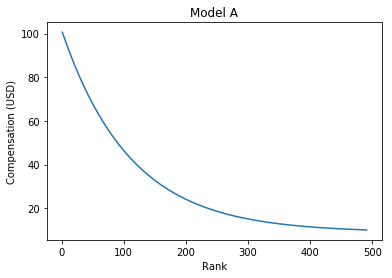

In [74]:
graph(lambda rank: alpha*np.exp(-beta*rank)+base, np.arange(1,500,10), 'Model A')

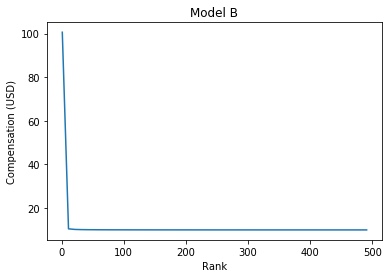

In [75]:
graph(lambda rank: gamma*np.exp(delta/rank)+base, np.arange(1,500,10), 'Model B')

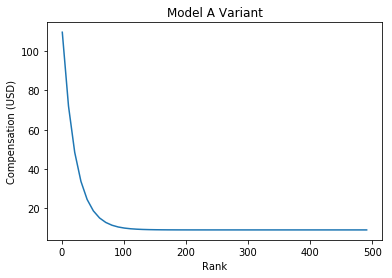

In [76]:
# I can't for the life of me remember where I derived
# this from which prompted me to come up with the above ones.
factor = 0.04678 
graph(lambda x: ((top)/np.exp(-factor))*np.exp(-x*factor) + base,np.arange(1,500,10), 'Model A Variant')

The Arrenhius equation can be linearized by taking the $\log$ of both sides of the equation (this is how it is done in chemistry labs to simplify calcuations or find the activation energy). The new equation looks like this: $$\ln(k) = \frac{-E_a}{R}\left(\frac{1}{T}\right)+\ln(A).$$ When we translate this to our two variations (A) and (B) we get:
$$\begin{align}
\log(c-b) &= -\beta R +  \log \alpha & (A)\\
\log(c-b) &= \frac{\delta}{R} +  \log \gamma & (B)
\end{align}$$

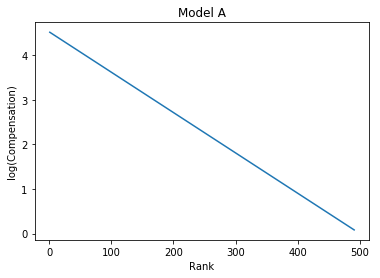

In [77]:
graph(lambda rank: -beta*rank + log(alpha) ,np.arange(1,500,10),
     title='Model A', xlabel='Rank', ylabel='log(Compensation)')

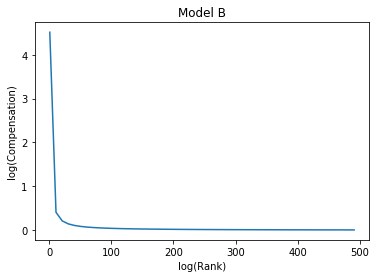

In [78]:
graph(lambda rank: delta / rank + log(gamma) ,np.arange(1,500,10),
     title='Model B', xlabel='log(Rank)', ylabel='log(Compensation)')

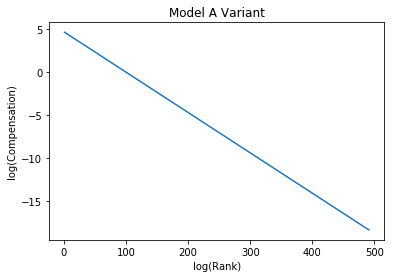

In [79]:
graph(lambda x: log(top/np.exp(-factor))-factor*x,np.arange(1,500,10),
     title='Model A Variant', xlabel='log(Rank)', ylabel='log(Compensation)')

From the above graphs of the linearized versions we can see that we have to discard Model B because it's not actually linear in this form.

## Convert the Data to the log form
We will use the pandas `apply()` method to create a new column `ceo_pay_20XX[log(Compensation)]` where the XX will be replaced with 15, 16 and 17.

In [81]:
ceo_pay_2015['log(Compensation)'] = ceo_pay_2015['Compensation'].apply(lambda s: log(s - base))
ceo_pay_2016['log(Compensation)'] = ceo_pay_2016['Compensation'].apply(lambda s: log(s - base))
ceo_pay_2017['log(Compensation)'] = ceo_pay_2017['Compensation'].apply(lambda s: log(s - base))

## Plot the Data in log form to see how linear it is

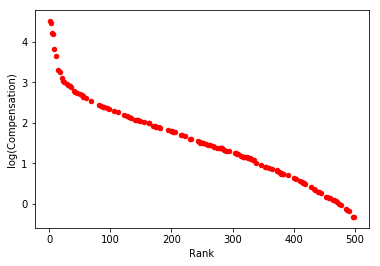

In [84]:
ceo_pay_2015.plot.scatter(x = 'Rank' , y ='log(Compensation)', color='r')

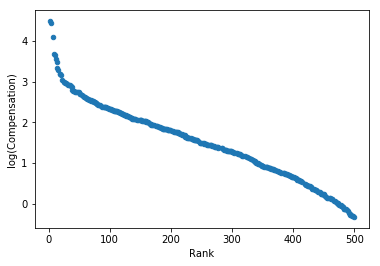

In [86]:
ceo_pay_2016.plot.scatter(x = 'Rank' , y ='log(Compensation)')

## Segment the data by Gender
Since we are tyring to see if CEO pay is a function of company rank and avoids gender, we will separate the data by gender before building a model and use the female CEO data as a holdout test. Then we'll randomly sample the male data to also make a test set.

In [111]:
ceo_pay_by_year_m = ceo_pay_by_year[ceo_pay_by_year['Ceo'].isin(list(male_ceo_pay['Ceo'].values))].copy()
ceo_pay_by_year_f = ceo_pay_by_year[ceo_pay_by_year['Ceo'].isin(list(female_ceo_pay['Ceo'].values))].copy()

ceo_pay_by_year_m['log(Compensation)'] = ceo_pay_by_year_m['Compensation'].apply(lambda s: log(s - base))
ceo_pay_by_year_f['log(Compensation)'] = ceo_pay_by_year_f['Compensation'].apply(lambda s: log(s - base))

ceo_pay_2015_m = ceo_pay_by_year_m[ceo_pay_by_year_m.Year == 2015].copy()
ceo_pay_2016_m = ceo_pay_by_year_m[ceo_pay_by_year_m.Year == 2016].copy()
ceo_pay_2017_m = ceo_pay_by_year_m[ceo_pay_by_year_m.Year == 2017].copy()

ceo_pay_2015_f = ceo_pay_by_year_f[ceo_pay_by_year_f.Year == 2015].copy()
ceo_pay_2016_f = ceo_pay_by_year_f[ceo_pay_by_year_f.Year == 2016].copy()
ceo_pay_2017_f = ceo_pay_by_year_f[ceo_pay_by_year_f.Year == 2017].copy()

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    ceo_pay_by_year_m['Rank'],
    ceo_pay_by_year_m['log(Compensation)'],
    test_size=0.33,
    random_state=42)

In [166]:
lin_model = LinearRegression(normalize=True) #normalize=True produces almost the same coef and int.
lin_model.fit(X = X_train.values.reshape(-1,1), y = y_train)
print('Linear Model:\nln(c-c_0) = {:.4}R + {:.4}'.format(lin_model.coef_[0],lin_model.intercept_))
MSE_m = mean_squared_error(y_test.values.reshape(-1,1), lin_model.predict(X_test.values.reshape(-1,1)))
r_squared_m = r2_score(y_test.values.reshape(-1,1), lin_model.predict(X_test.values.reshape(-1,1)))
lin_r_squared_m = lin_model.score(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1))

print('MSE: {:.5e}\nR squared: {:.5e}\nR squared from LinearRegression: {:.5e}'.format(
        MSE_m, r_squared_m, lin_r_squared_m
    ))

Linear Model:
ln(c-c_0) = -0.006362R + 3.108
MSE: 4.86919e-02
R squared: 9.57430e-01
R squared from LinearRegression: 9.57430e-01


In [168]:
MSE_f = mean_squared_error(
            ceo_pay_by_year_f['log(Compensation)'].values.reshape(-1,1),
            lin_model.predict(ceo_pay_by_year_f['Rank'].values.reshape(-1,1)))
r_squared_f = r2_score(
            ceo_pay_by_year_f['log(Compensation)'].values.reshape(-1,1),
            lin_model.predict(ceo_pay_by_year_f['Rank'].values.reshape(-1,1)))
lin_r_squared_f = lin_model.score(ceo_pay_by_year_f['Rank'].values.reshape(-1,1),
                    ceo_pay_by_year_f['log(Compensation)'].values.reshape(-1,1))

print('MSE: {:.5e}\nR squared: {:.5e}\nR squared from LinearRegression: {:.5e}'.format(
   MSE_f, r_squared_f, lin_r_squared_f
    ))

MSE: 1.98205e-02
R squared: 9.80532e-01
R squared from LinearRegression: 9.80532e-01


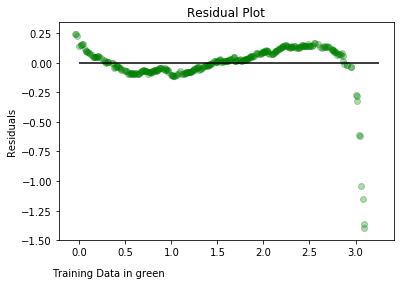

In [205]:
plt.scatter(
    lin_model.predict(X_train.values.reshape(-1,1)),
    lin_model.predict(X_train.values.reshape(-1,1)).reshape(-1,1) - y_train.values.reshape(-1,1),
    c='g', alpha=0.3 )
plt.hlines(y=0, xmin=0, xmax=3.25)
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.text(x=-0.3, y=-1.8, s='Training Data in green')

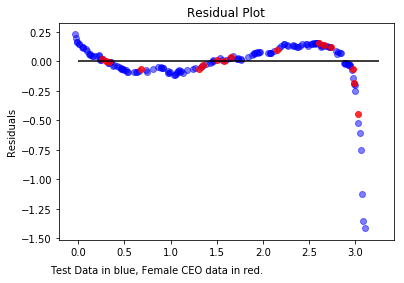

In [204]:
plt.scatter(
    lin_model.predict(X_test.values.reshape(-1,1)),
    lin_model.predict(X_test.values.reshape(-1,1)).reshape(-1,1) - y_test.values.reshape(-1,1),
    c='b', alpha=0.5)
plt.scatter(
    lin_model.predict(ceo_pay_by_year_f['Rank'].values.reshape(-1,1)),
    lin_model.predict(
        ceo_pay_by_year_f['Rank'].values.reshape(-1,1)).reshape(-1,1) - \
            ceo_pay_by_year_f['log(Compensation)'].values.reshape(-1,1),
    c='r', alpha=0.8 )
plt.hlines(y=0, xmin=0, xmax=3.25)
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.text(x=-0.3, y=-1.8, s='Test Data in blue, Female CEO data in red.')